# Data Wrangling & Analysis: Movies and Box Office

**Data Sources**
The analysis uses three separate CSV datasets obtained from Kaggle:
1. Movie Ratings Dataset – Contains user ratings for movies (userId, movie_id, rating, timestamp).
2. Movie Details Dataset – Includes movie metadata like Title and genres.
3. Box Office Dataset – Contains gross revenue for movies (Title, Gross).

The datasets were merged using the movie_id as the primary key to combine ratings with metadata when possible, and Title was used to link box office revenue. This setup allowed a comprehensive analysis of both audience ratings and financial performance.

**Questions to Answer:**

1. Which movies have the highest average rating?  
2. Which movies earned the most at the box office?  
3. Which genres generate the highest total revenue and average ratings?  
4. Is there a correlation between average rating and box office revenue?  
5. Which movies are outliers in revenue vs. ratings?


#Acquisition/Exploration

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

In [135]:
box_df = pd.read_csv("C:/Users/Ricki/.cache/kagglehub/datasets/harios/box-office/versions/1/boxoffice_data_2024.csv")
movie_df = pd.read_csv("C:/Users/Ricki/.cache/kagglehub/datasets/harios/box-office/versions/1/movie.csv")
rating_df = pd.read_csv("C:/Users/Ricki/.cache/kagglehub/datasets/harios/box-office/versions/1/rating.csv")

In [136]:
box_df.head()

,Year,Title,Gross
0,1984,Beverly Hills Cop,"$234,760,478"
1,1984,Ghostbusters,"$229,376,332"
2,1984,Indiana Jones and the Temple of Doom,"$179,876,727"
3,1984,Gremlins,"$148,171,538"
4,1984,The Karate Kid,"$90,817,155"


In [158]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [138]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


#Cleaning the title column
Some titles in one dataset included the release year (e.g., "Jumanji (1995)") while the other dataset had just "Jumanji". To prevent duplicate or mismatched rows during the merge, I removed the year from the title column so that both datasets have consistent movie titles. This ensures that the inner merge correctly pairs each movie’s ratings with its box office data.

Merging datasets: The first merge was done on movieId because it is the unique identifier for each movie, ensuring that ratings match the correct movies. After this, the movie titles were cleaned to remove the year in parentheses for consistency. The second merge (with the third dataset) was done on the title column, since the third dataset didn’t include movieId. This ensures that all available information aligns correctly across the datasets.

-Setting movie_id as the index
I set movie_id as the index to make data lookup easier and prevent duplicate rows from interfering with analysis. This also makes the dataframe more organized and ready for further analysis.

In [139]:
movies_and_ratings = movie_df.merge(rating_df, how="inner", on="movieId")
movies_and_ratings['title'] = movies_and_ratings['title'].str.replace(r'\s*\(\d{4}\)$', '', regex=True)

In [140]:
clean_df = movies_and_ratings.merge(box_df, 
                                    left_on="title", 
                                    right_on="Title", 
                                    how="inner").set_index("movieId", inplace=False)

In [141]:
movies_and_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1999-12-11 13:36:47
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,6,5.0,1997-03-13 17:50:52
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,8,4.0,1996-06-05 13:37:51
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,10,4.0,1999-11-25 02:44:47
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,11,4.5,2009-01-02 01:13:41


In [142]:
movies_and_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   title      object 
 2   genres     object 
 3   userId     int64  
 4   rating     float64
 5   timestamp  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


#Data Cleaning

Before starting analysis, the dataset was cleaned and prepared:

1. Select Relevant Columns – Chose only the columns needed for analysis (Title, Genres, UserId, Rating, Timestamp, Year, Gross) and dropped any duplicates or irrelevant data.
2. Format Column Names – Replaced underscores with spaces and converted to title case for readability.
3. Clean Gross Column – Removed dollar signs and commas, then converted the column to numeric so it can be used in calculations and aggregations.

In [143]:
clean_df=clean_df[["Title", "genres", "userId", "rating", "timestamp", "Year", "Gross"]] #Choosing column order, dropping duplicate columns
clean_df.columns = [col.replace('_', ' ').title() for col in clean_df.columns] #Drops underscores from column names, makes Titlecase
clean_df["Gross"] = clean_df["Gross"].str.replace("$","").str.replace(",","") #Drops dollar signs, drops commas in Gross column
clean_df["Gross"] = pd.to_numeric(clean_df["Gross"], errors="coerce")#Makes Gross column type numeric for future calculations.

clean_df.head()

,Title,Genres,Userid,Rating,Timestamp,Year,Gross
movieId,,,,,,,
1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1999-12-11 13:36:47,1995,244652254
1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,6,5.0,1997-03-13 17:50:52,1995,244652254
1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,8,4.0,1996-06-05 13:37:51,1995,244652254
1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,10,4.0,1999-11-25 02:44:47,1995,244652254
1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,11,4.5,2009-01-02 01:13:41,1995,244652254


#Grouping by Title and Year to Identify Top Movies

To determine the top-performing movies, we grouped the dataset by Title and Year. For each movie, we calculated:
-Mean Rating – The average user rating for the movie.
-Mean Gross – The average box office revenue.

This allowed us to identify:
-The 5 highest-rated movies based on average user ratings.
-The 5 highest-grossing movies based on box office revenue.

These metrics provide a clear view of which movies performed best both critically and commercially.

In [144]:
grouped_title_rating_mean = clean_df.groupby(["Title", "Year"])["Rating"].mean().sort_values(ascending=False).head(5)
print("Top 5 Movies by Rating")
grouped_title_rating_mean

Top 5 Movies by Rating


Title                     Year
The Floating Castle       2012    5.000000
Stand by Me Doraemon      2014    4.500000
The Dark Knight           2008    4.500000
Detroit                   2017    4.500000
The Phantom of the Opera  1989    4.333333
Name: Rating, dtype: float64

In [145]:
top5 = grouped_title_gross_mean.head(5)
top5_formatted = top10.apply(lambda x: f"${x:,.0f}")  # formats as $2,742,344,000
print("Top 5 highest grossing movies at the Box Office")
top5_formatted

Top 5 Movies by Gross Sales at the Box Office


Title                                         Year
Avatar                                        2009    $2,743,577,587
Titanic                                       1997    $1,843,373,318
Harry Potter and the Deathly Hallows: Part 2  2011    $1,341,511,219
Frozen                                        2013    $1,280,802,282
Beauty and the Beast                          2017    $1,263,521,126
Iron Man 3                                    2013    $1,214,811,252
Transformers: Dark of the Moon                2011    $1,123,794,079
Skyfall                                       2012    $1,108,561,013
Transformers: Age of Extinction               2014    $1,104,054,072
Joker                                         2019    $1,078,751,311
Name: Gross, dtype: object

Separating and Exploding Genres

In the original dataset, the Genres column often contained multiple genres in a single string, separated by | (e.g., Horror|Adventure|Thriller). To enable proper comparison and aggregation by genre:
-Split the Genres – Each genre string was split into a Python list.
-Explode the Lists – Converted the lists into separate rows, so each movie-genre combination is represented as its own row. This makes it easier to calculate metrics like average rating and total revenue per genre.
-Group by Genre – After exploding, the dataset was grouped by genre to compute the mean of the Gross and Rating columns. This allowed for direct comparison across genres, which was visualized using a single line graph to show trends in both revenue and ratings simultaneously. This also allowed for visualizing which genres were rated higher on average and which genres brought in more at the Box Office.

In [146]:
clean_df['Genres'] = clean_df['Genres'].str.split('|')
df_exploded = clean_df.explode('Genres')
df_exploded.sample(5)

,Title,Genres,Userid,Rating,Timestamp,Year,Gross
movieId,,,,,,,
288,Natural Born Killers,Action,28711,1.0,1996-08-29 13:44:59,1994,50283942
555,True Romance,Crime,125091,3.0,2002-06-17 19:47:48,1993,13088778
2389,Psycho,Crime,48909,3.0,2015-02-19 04:22:39,1998,37170655
3555,U-571,War,51005,3.0,2001-06-16 19:26:35,2000,127666415
1411,Hamlet,Drama,117152,5.0,1997-01-23 17:34:55,1996,4739189


In [147]:
genre_box_results = df_exploded.groupby("Genres")["Gross"].mean().sort_values(ascending=False)
genre_rating_results = df_exploded.groupby("Genres")["Rating"].mean().sort_values(ascending=False)

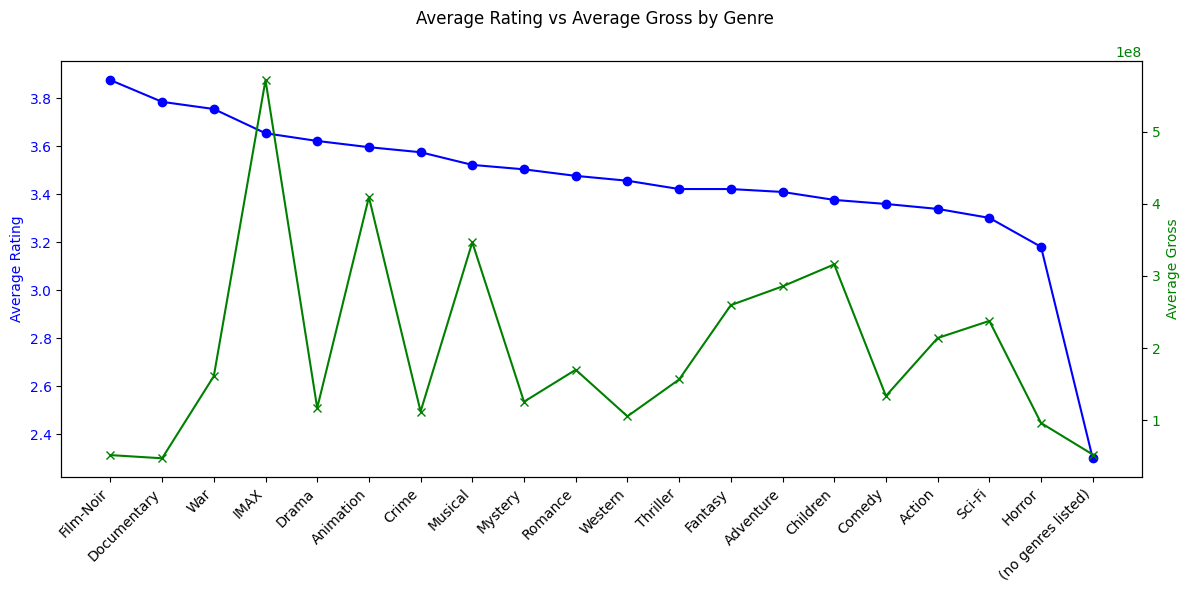

In [148]:
genre_compare = genre_rating_results.to_frame("Rating").join(
    genre_box_results.to_frame("Gross")
)

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(genre_compare.index, genre_compare["Rating"], color='blue', marker='o', label='Average Rating')
ax1.set_ylabel('Average Rating', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(genre_compare.index, genre_compare["Gross"], color='green', marker='x', label='Average Gross')
ax2.set_ylabel('Average Gross', color='green')
ax2.tick_params(axis='y', labelcolor='green')

fig.suptitle("Average Rating vs Average Gross by Genre")
fig.tight_layout()
plt.show()


#Correlation Between Average Rating and Box Office Gross

To investigate whether higher-rated movies tend to earn more at the box office:
1. Grouped by Title – Aggregated the dataset by movie title to calculate:
        -Average Rating – the mean of all user ratings for each movie.
        -Total Gross – the sum of box office sales for each movie.
2. Correlation Analysis – Calculated the correlation coefficient between average rating and total gross to quantify the relationship.
3. Visualization – Created a scatter plot with average rating on the x-axis and total gross on the y-axis to visually inspect patterns and outliers.

This analysis helps determine whether there’s a meaningful relationship between how well a movie is rated and its box office performance.

Correlation between rating and gross: 0.15038815394344726


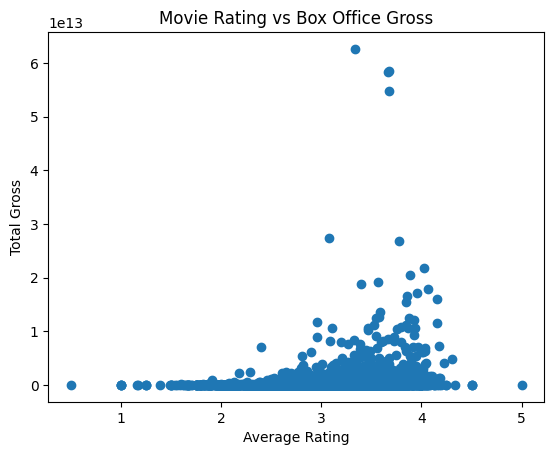

In [149]:
movie_metrics = clean_df.groupby("Title").agg({"Rating": "mean", "Gross": "sum"})
corr_value = movie_metrics["Rating"].corr(movie_metrics["Gross"])
print("Correlation between rating and gross:", corr_value)

plt.scatter(movie_metrics["Rating"], movie_metrics["Gross"])
plt.xlabel("Average Rating")
plt.ylabel("Total Gross")
plt.title("Movie Rating vs Box Office Gross")
plt.show()

In [150]:
movie_metrics[["Gross", "Rating"]].corr()

,Gross,Rating
Gross,1.000000,0.150388
Rating,0.150388,1.000000


#Findings

-The correlation coefficient between average rating and total gross is 0.15038815394344726.
-Movies with higher ratings do not necessarily make more money—some highly rated films earn less than average, while some moderately rated movies gross significantly.
-Outliers are visible on the scatter plot and highlight interesting cases for further exploration.

#Analyzing Ratings Over Time

-Converted the Timestamp column into datetime objects to enable time-based analysis.
-Created a new Year column extracted from the timestamp.
-Grouped the dataset by Title and Year to calculate the average rating for each movie per year.
-Filtered the results to view how ratings for a specific movie (e.g., "Napoleon Dynamite") changed over time.

Example: Ratings Over Time for a Single Movie

To demonstrate how the dataset can be filtered and analyzed over time, I selected a single movie (e.g., "Star Wars") to see how its average ratings changed year by year. This highlights the ability to:

-Filter by movie title
-Group by year
-Calculate time-based metrics

In [151]:
clean_df["Timestamp"] = pd.to_datetime(clean_df["Timestamp"], errors="coerce")
clean_df["Year"] = clean_df["Timestamp"].dt.year 
ratings_over_time = clean_df.groupby(["Title", "Year"])["Rating"].mean().reset_index()

In [152]:
#Easily view the ratings for a specific movie and how they may have changed over time.
movie_ratings = ratings_over_time[ratings_over_time["Title"].str.contains("Dynamite")] #Insert Any Movie Title
movie_ratings.head(15)

,Title,Year,Rating
30650,Napoleon Dynamite,2004,3.660656
30651,Napoleon Dynamite,2005,3.551688
30652,Napoleon Dynamite,2006,3.439979
30653,Napoleon Dynamite,2007,3.322222
30654,Napoleon Dynamite,2008,3.298212
30655,Napoleon Dynamite,2009,3.336414
30656,Napoleon Dynamite,2010,3.215139
30657,Napoleon Dynamite,2011,3.198895
30658,Napoleon Dynamite,2012,3.230126
30659,Napoleon Dynamite,2013,3.261538


#Identifying Outlier Movies
To highlight interesting anomalies in the dataset, I looked for movies that were statistical outliers in terms of ratings and box office gross. Specifically:

1.High Gross but Low Rating – Movies that earned a lot at the box office but received unusually low average ratings.
2.Low Gross but High Rating – Movies that earned relatively little but received unusually high ratings.

To determine these outliers:
-I calculated the 5th and 95th percentiles for both Gross and Rating.
-Movies beyond these thresholds were flagged as outliers.
-This method identifies extremes while ignoring the majority of “typical” movies.

This approach provides insight into which films were over- or under-appreciated relative to their financial success.

In [153]:
movie_summary = clean_df.groupby("Title").agg({"Rating": "mean", "Gross": "max"}).reset_index()

# Sets thresholds at the 3rd and 97th percentiles to identify outliers in Gross and Rating
gross_high = movie_summary['Gross'].quantile(0.95)
gross_low  = movie_summary['Gross'].quantile(0.05)
rating_high = movie_summary['Rating'].quantile(0.95)
rating_low  = movie_summary['Rating'].quantile(0.05)

In [154]:
# Identifies movies that are statistical outliers:
high_gross_low_rating = movie_summary[(movie_summary['Gross'] >= gross_high) & (movie_summary['Rating'] <= rating_low)]
low_gross_high_rating = movie_summary[(movie_summary['Gross'] <= gross_low) & (movie_summary['Rating'] >= rating_high)]

print("High gross but low rating:")
print(high_gross_low_rating)

High gross but low rating:
                                     Title    Rating      Gross
150   Alvin and the Chipmunks: Chipwrecked  2.053030  342695435
1201                  Fifty Shades of Grey  1.807292  569651467


In [155]:
print("\nLow gross but high rating:")
print(low_gross_high_rating)


Low gross but high rating:
                             Title    Rating    Gross
45                           35 Up  3.995522   922872
115                          Akira  3.862806   830239
203          Anne Frank Remembered  3.937302  1310200
309                         Baraka  4.051042  1256698
549               Brother's Keeper  3.904570  1305915
780                       Crackers  4.000000   129268
1002                   Down by Law  4.030624  1435668
1179  Fast, Cheap & Out of Control  3.875764   878960
1260               For All Mankind  3.972656   770132
1522                 Heavy Petting  4.000000   272371
2724                       Ponette  3.864583  1300377
3363          Swimming to Cambodia  3.952261  1092911
3747                         Water  3.860681  1256862


In [156]:
outliers = pd.concat([high_gross_low_rating, low_gross_high_rating])
outliers.sort_values(by="Rating", ascending=False)
print("Top 15 biggest outliers")
outliers

Top 15 biggest outliers


,Title,Rating,Gross
150,Alvin and the Chipmunks: Chipwrecked,2.053030,342695435
1201,Fifty Shades of Grey,1.807292,569651467
45,35 Up,3.995522,922872
115,Akira,3.862806,830239
203,Anne Frank Remembered,3.937302,1310200
309,Baraka,4.051042,1256698
549,Brother's Keeper,3.904570,1305915
780,Crackers,4.000000,129268
1002,Down by Law,4.030624,1435668
1179,"Fast, Cheap & Out of Control",3.875764,878960


#Summary of Findings

After analyzing the movies and box office dataset, several key insights emerged:

##Top Movies by Rating:
The highest-rated movies include The Floating Castle, Stand by Me Doraemon, The Dark Knight, Detroit, and The Phantom of the Opera. These films consistently received strong ratings from viewers, indicating broad audience appreciation.

##Top Grossing Movies:
In terms of revenue, Avatar, Titanic, Harry Potter and the Deathly Hallows: Part 2, Frozen, and Beauty and the Beast were the most successful at the box office. High grossing films tend to attract large audiences, often through franchise popularity or broad appeal.

##Genres Performance:
When examining genres, IMAX, Animation, Musical, Children, and Adventure had the highest total revenue, highlighting the commercial strength of family-friendly and visually spectacular films. In contrast, the genres with the highest average ratings were Film Noir, Documentaries, War, IMAX, and Drama, showing that critical acclaim does not always align with box office success.

#Correlation Between Ratings and Gross:
The correlation between average movie rating and box office revenue is 0.14, suggesting only a very weak positive relationship. In other words, higher ratings slightly relate to higher gross, but other factors like marketing, franchise, or release timing likely play a larger role in revenue.

#Outliers:
Several movies stand out as outliers in revenue versus ratings, either earning high gross with low ratings or low gross with high ratings. Notable examples include Alvin and the Chipmunks: Chipwrecked, Fifty Shades of Grey, Akira, Anne Frank Remembered, and Swimming to Cambodia. These films illustrate how popularity and critical reception do not always align.

## Conclusion

This project successfully merged and cleaned multiple movie datasets, creating a unified dataset ready for analysis. The workflow demonstrates careful data cleaning, merging strategies, and attention to detail—key skills in data wrangling and analysis.
